# Predicting Arrests in Chicago

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np

# import seaborn as sns # install seaborn with either pip or conda, used for heat maps
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# import DataSet
from util.data_util import DataSet

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, precision_recall_curve, \
precision_score, precision_recall_fscore_support, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Load data

In [2]:
def create_master_df():
    cleaned_data = 'cleaned_data.zip'
    ds = DataSet(cleaned_data)
    data = ds.load_subset(['2010'])
    df = data.apply(pd.to_numeric, errors = 'ignore')

    root_dir = os.getcwd()
    com_data = os.path.join(root_dir, 'data', 'Per_Capita_Income.csv')
    com_df = pd.read_csv(com_data)
    com_df = com_df.apply(pd.to_numeric, errors='ignore')

    com_df.fillna(0)
    com_df = com_df.rename(columns={'Community Area Number': 'Community Area'})
    df = df[df['Community Area'] != 0]
    df = df.merge(com_df, how='left', on='Community Area')

    df.drop(['Block'], axis=1, inplace=True)
    df.drop(['Description'], axis=1, inplace=True)
    df.drop(['Location Description'], axis=1, inplace=True)
    df.drop(['Updated On'], axis=1, inplace=True)
    df.drop(['Location'], axis=1, inplace=True)
    df.drop(['COMMUNITY AREA NAME'], axis=1, inplace=True)
    df.drop(['Year'], axis=1, inplace=True)
    
    return df

In [3]:
master_data = create_master_df()

C:\Users\6J3034897\Documents\uw\f21\stat451\project\CrimeAnalysisML\data\cleaned_data.zip
downloading: data/2010/data_2010.csv ...
done.
build DataFrame ...


In [4]:
master_data.head()

,Arrest,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Latitude,Longitude,...,Radius,Angle,Type,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,0,0,323,3.0,6.0,69.0,1183191.0,1855830.0,41.759594,-87.604169,...,97.048205,2.696770,9,3.6,29.6,23.0,16.5,41.0,17285,66.0
1,1,0,924,9.0,12.0,61.0,1161779.0,1875003.0,41.812678,-87.682112,...,97.141406,2.696622,23,11.9,29.0,23.0,41.5,38.9,12765,91.0
2,1,0,1124,11.0,2.0,27.0,1156795.0,1899213.0,41.879216,-87.699738,...,97.185970,2.696082,18,8.2,42.4,19.6,21.3,43.2,12961,83.0
3,0,0,1834,18.0,42.0,8.0,1177342.0,1903838.0,41.891466,-87.624153,...,97.123051,2.695633,9,1.9,12.9,7.0,2.5,22.6,88669,1.0
4,1,0,1112,11.0,27.0,23.0,1150571.0,1905280.0,41.895988,-87.722433,...,97.213677,2.696027,18,14.8,33.9,17.3,35.4,38.0,13781,85.0


In [5]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369793 entries, 0 to 369792
Data columns (total 40 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Arrest                                        369793 non-null  int64  
 1   Domestic                                      369793 non-null  int64  
 2   Beat                                          369793 non-null  int64  
 3   District                                      369793 non-null  float64
 4   Ward                                          369793 non-null  float64
 5   Community Area                                369793 non-null  float64
 6   X Coordinate                                  369793 non-null  float64
 7   Y Coordinate                                  369793 non-null  float64
 8   Latitude                                      369793 non-null  float64
 9   Longitude                                     36

## Refactor feature columns

In [6]:
def one_hot_encode(train_data, categories):
    encoded_df = train_data
    for cat in categories:
        encoded_df = pd.concat([encoded_df, 
                                    pd.get_dummies(pd.Series(encoded_df[cat]), prefix=cat)], axis=1)
    encoded_df = encoded_df.drop(categories, axis=1)
    
    return encoded_df

### One hot encode all features

In [7]:
feature_cols = ['Beat', 'District', 'Ward', 'Community Area', 'Month', 'dayOfWeek',
               'dayOfYear', 'weekOfMonth', 'weekOfYear', 'Hour', 'Day', 'Minute', 'Holiday',
                'Season', 'Cluster', 'Type']

one_hot = one_hot_encode(master_data, feature_cols)
one_hot.shape

(369793, 1109)

### Create sample of dataset

In [8]:
sample = one_hot.sample(frac=0.3, random_state=123)
sample.shape

(110938, 1109)

## Generate training and test sets

In [9]:
X, y = sample.drop('Arrest', axis=1).copy(), sample['Arrest']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True,
                                                   stratify=y)


X_train, X_valid, y_train, y_valid = \
    train_test_split(X_temp, y_temp, test_size=0.2, random_state=1, stratify=y_temp)
print('Train/Valid/Test sizes:', y_train.shape[0], y_valid.shape[0], y_test.shape[0])

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

Train/Valid/Test sizes: 62124 15532 33282
X_train.shape: (62124, 1108)
y_train.shape: (62124,)
X_test.shape: (33282, 1108)
y_test.shape: (33282,)


## Baseline models

In [10]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train.values, y_train.values)
print(f"Train Accuracy: {knn.score(X_train.values, y_train.values)*100:0.3f}%")
print(f"Valid Accuracy: {knn.score(X_valid.values, y_valid.values)*100:0.3f}%")
print("Test Accuracy: %0.3f" % knn.score(X_test.values, y_test.values))

y_pred = knn.predict(X_test.values)

Train Accuracy: 79.646%
Valid Accuracy: 71.330%
Test Accuracy: 0.718


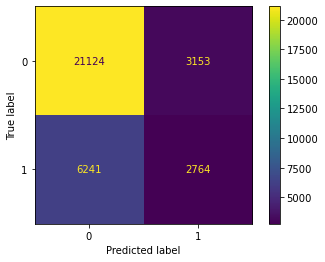

In [11]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [12]:
knn_loss = log_loss(y_test, y_pred)
pr_score = precision_score(y_test, y_pred)
print('KNN Validation Log Loss: ', knn_loss)
print('KNN Precision Score    : ', pr_score)

KNN Validation Log Loss:  9.748806759944967
KNN Precision Score    :  0.4671286124725368


### Analyze X and y datasets for imbalance 

In [13]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [14]:
sample['Arrest'].value_counts()

0    80923
1    30015
Name: Arrest, dtype: int64

There is an imbalance of class labels in our data set.
- accuracy of just selecting non-arrest = 0.729

### rebuild train and test

In [15]:
sample = one_hot.sample(frac=0.3, random_state=123)

X, y = sample.drop("Arrest", axis=1).copy(), sample['Arrest']

smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_temp, X_test, y_temp, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True,
                                                   stratify=y_resampled)


X_train, X_valid, y_train, y_valid = \
    train_test_split(X_temp, y_temp, test_size=0.2, random_state=1, stratify=y_temp)
print('Train/Valid/Test sizes:', y_train.shape[0], y_valid.shape[0], y_test.shape[0])

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

Train/Valid/Test sizes: 90633 22659 48554
X_train.shape: (90633, 1108)
y_train.shape: (90633,)
X_test.shape: (48554, 1108)
y_test.shape: (48554,)


Train Accuracy: 79.013%
Valid Accuracy: 68.158%
Test Accuracy : 68.128%
KNN Validation Log Loss:  11.008249791760917
KNN Precision Score    :  0.6673384030418251


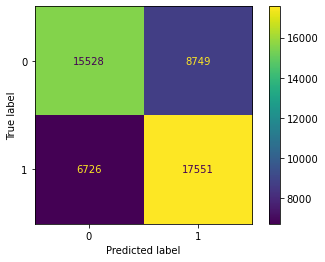

In [16]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train.values, y_train.values)
print(f"Train Accuracy: {knn.score(X_train.values, y_train.values)*100:0.3f}%")
print(f"Valid Accuracy: {knn.score(X_valid.values, y_valid.values)*100:0.3f}%")
print(f"Test Accuracy : {knn.score(X_test.values, y_test.values)*100:0.3f}%")

y_pred = knn.predict(X_test.values)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

knn_loss = log_loss(y_test, y_pred)
pr_score = precision_score(y_test, y_pred)
print('KNN Validation Log Loss: ', knn_loss)
print('KNN Precision Score    : ', pr_score)

### let's try 10 neighbors

Train Accuracy: 73.810%
Valid Accuracy: 66.883%
Test Accuracy : 67.026%
KNN Validation Log Loss:  11.388806139949878
KNN Precision Score    :  0.6723512488012342


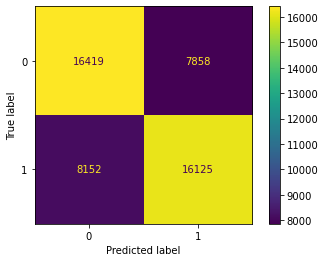

In [17]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train.values, y_train.values)
print(f"Train Accuracy: {knn.score(X_train.values, y_train.values)*100:0.3f}%")
print(f"Valid Accuracy: {knn.score(X_valid.values, y_valid.values)*100:0.3f}%")
print(f"Test Accuracy : {knn.score(X_test.values, y_test.values)*100:0.3f}%")

y_pred = knn.predict(X_test.values)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

knn_loss = log_loss(y_test, y_pred)
pr_score = precision_score(y_test, y_pred)
print('KNN Validation Log Loss: ', knn_loss)
print('KNN Precision Score    : ', pr_score)

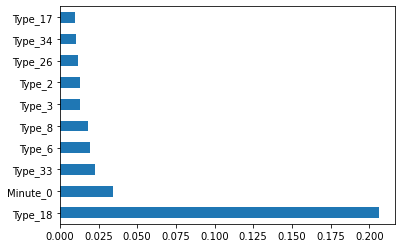

In [18]:
model = ExtraTreesClassifier()
data_sample = sample.drop('Arrest', axis=1).copy()

model.fit(data_sample, sample['Arrest'])

feat_importances = pd.Series(model.feature_importances_, index=data_sample.columns)

feat_importances.nlargest(10).plot(kind='barh')
plt.show()

<AxesSubplot:>

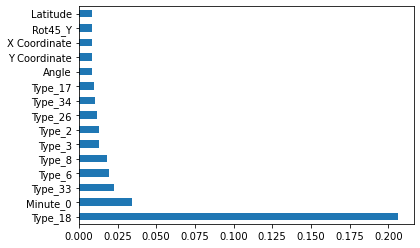

In [19]:
feat_importances.nlargest(15).plot(kind='barh')

# Hyper param tuning

In [23]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
import hyperopt.pyll.stochastic
from sklearn.model_selection import StratifiedKFold
import numpy as np
import optuna

In [24]:
def optimization_objective(trial, X_train, y_train, cv=5):

    
    params =  {
            "n_estimators": trial.suggest_categorical("n_estimators", [30, 50, 100, 300]),
            "learning_rate": trial.suggest_categorical("learning_rate", [0.01]),
            "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }
    

    cv_iterator = StratifiedKFold(n_splits=cv, shuffle=True, random_state=123)

    cv_scores = np.zeros(cv)
    for idx, (train_sub_idx, valid_idx) in enumerate(cv_iterator.split(X_train, y_train)):
        
        X_train_sub, X_valid = X_train[train_sub_idx], X_train[valid_idx]
        y_train_sub, y_valid = y_train[train_sub_idx], y_train[valid_idx]
        

        model = XGBClassifier(**params, random_state=123, use_label_encoder=False)
        
        model.fit(
            X_train_sub,
            y_train_sub,
            verbose=False,
            eval_set=[(X_valid, y_valid)],
            eval_metric="auc",
            early_stopping_rounds=100,
        )
        
        preds = model.score(X_valid, y_valid)
        
        cv_scores[idx] = preds

    return np.mean(cv_scores)

In [25]:
study = optuna.create_study(direction="maximize", study_name="XGBoost Classifier")

def func(trial):
    return optimization_objective(trial, X_train.values, y_train.values)

study.optimize(func, n_trials=25);

[I 2021-12-06 14:23:40,377] A new study created in memory with name: XGBoost Classifier
[I 2021-12-06 14:25:24,926] Trial 0 finished with value: 0.8458177846679991 and parameters: {'n_estimators': 50, 'learning_rate': 0.01, 'lambda': 4.284692201228077e-08, 'alpha': 1.4305964573432777e-07}. Best is trial 0 with value: 0.8458177846679991.
[I 2021-12-06 14:28:47,562] Trial 1 finished with value: 0.8520406990775744 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'lambda': 0.07040188550895629, 'alpha': 0.0018062801105899217}. Best is trial 1 with value: 0.8520406990775744.
[I 2021-12-06 14:38:45,305] Trial 2 finished with value: 0.8953913747731601 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'lambda': 0.008794681428319863, 'alpha': 1.6370420793053065e-08}. Best is trial 2 with value: 0.8953913747731601.
[I 2021-12-06 14:39:52,538] Trial 3 finished with value: 0.8343760268169582 and parameters: {'n_estimators': 30, 'learning_rate': 0.01, 'lambda': 0.0014143031972

KeyboardInterrupt: 

In [ ]:
print(f"Best CV accuracy: {study.best_value:.5f}")
print("Best params:")

for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

In [ ]:
model = XGBClassifier(**study.best_params, random_state=123, use_label_encoder=False)
model.fit(
    X_train,
    y_train,
    verbose=False,
    eval_set=[(X_valid, y_valid)],
    eval_metric="auc",
    early_stopping_rounds=100,
)

In [ ]:
print(f"Training Accuracy: {model.score(X_train, y_train):0.3f}")
print(f"Test Accuracy: {model.score(X_test, y_test):0.3f}")

In [ ]:
# {'n_estimators': 300, 'learning_rate': 0.01, 'lambda': 0.008794681428319863, 'alpha': 1.6370420793053065e-08}